# TESTING geopandas

## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import datetime
import shapely

import json
import fiona

from pathlib import Path

## MISC.

In [2]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

In [3]:
cm=1/2.54

In [4]:
## Paths

In [5]:
path_geo = Path('/home/lemasle/GEO/test_geospatial')
path_plots = Path('/home/lemasle/GEO/test_geospatial/plots/')
path_data = Path('/home/lemasle/GEO/test_geospatial/data/')

## DATA - Germany

Data source: https://www.suche-postleitzahl.org

In [6]:
zip_shapes = gpd.read_file('/home/lemasle/GEO/test_geospatial/data/plz-5stellig.shp')
zip_shapes.head()

,plz,note,qkm,einwohner,geometry
0,01067,01067 Dresden,6.866862,11957,"POLYGON ((13.68689 51.06395, 13.68734 51.06400..."
1,01069,01069 Dresden,5.351833,25491,"MULTIPOLYGON (((13.72009 51.04664, 13.72051 51..."
2,01097,01097 Dresden,3.297752,14821,"POLYGON ((13.72548 51.06860, 13.72629 51.06900..."
3,01099,01099 Dresden,58.506789,28018,"POLYGON ((13.74218 51.08979, 13.74231 51.08969..."
4,01108,01108 Dresden,16.447222,5876,"POLYGON ((13.76543 51.17491, 13.76567 51.17483..."


In [7]:
# It is possible to retrieve zipcodes for any city, e.g., Heidelberg
hd_shapes = zip_shapes.loc[zip_shapes['note'].str.contains('Heidelberg')]
hd_shapes

,plz,note,qkm,einwohner,geometry
4838,69115,69115 Heidelberg,4.094687,21900,"POLYGON ((8.66181 49.41177, 8.66427 49.41124, ..."
4839,69117,69117 Heidelberg,14.649721,11052,"POLYGON ((8.69239 49.41191, 8.69414 49.41213, ..."
4840,69118,69118 Heidelberg,24.217853,13468,"POLYGON ((8.71887 49.41545, 8.71995 49.41574, ..."
4841,69120,69120 Heidelberg,5.227405,15981,"POLYGON ((8.65447 49.41895, 8.65653 49.41916, ..."
4842,69121,69121 Heidelberg,15.234193,16725,"POLYGON ((8.64655 49.43663, 8.64722 49.43688, ..."
4843,69123,69123 Heidelberg,17.392849,18293,"POLYGON ((8.58292 49.42651, 8.58351 49.42654, ..."
4844,69124,69124 Heidelberg,15.938908,17066,"POLYGON ((8.61793 49.37928, 8.62038 49.37984, ..."
4845,69126,69126 Heidelberg,12.027798,32296,"POLYGON ((8.67244 49.36152, 8.67304 49.36352, ..."


In [8]:
lander = pd.read_csv(path_data / 'zuordnung_plz_ort.csv', sep=',', dtype={'plz': 'str'})
# imposing str dtype for zip codes mandatory otherwise those with leading 0s miss the first number
lander.head()

,osm_id,ags,ort,plz,landkreis,bundesland
0,1104550,8335001,Aach,78267,Landkreis Konstanz,Baden-Württemberg
1,1255910,7235001,Aach,54298,Landkreis Trier-Saarburg,Rheinland-Pfalz
2,62564,5334002,Aachen,52062,Städteregion Aachen,Nordrhein-Westfalen
3,62564,5334002,Aachen,52064,Städteregion Aachen,Nordrhein-Westfalen
4,62564,5334002,Aachen,52066,Städteregion Aachen,Nordrhein-Westfalen


In [9]:
germany = pd.merge(left=zip_shapes, right=lander, on='plz', how='inner').drop(columns=['osm_id'])
germany['bundesland'] = germany.bundesland.astype('category')
germany.head()

,plz,note,qkm,einwohner,geometry,ags,ort,landkreis,bundesland
0,01067,01067 Dresden,6.866862,11957,"POLYGON ((13.68689 51.06395, 13.68734 51.06400...",14612000,Dresden,NaN,Sachsen
1,01069,01069 Dresden,5.351833,25491,"MULTIPOLYGON (((13.72009 51.04664, 13.72051 51...",14612000,Dresden,NaN,Sachsen
2,01097,01097 Dresden,3.297752,14821,"POLYGON ((13.72548 51.06860, 13.72629 51.06900...",14612000,Dresden,NaN,Sachsen
3,01099,01099 Dresden,58.506789,28018,"POLYGON ((13.74218 51.08979, 13.74231 51.08969...",14612000,Dresden,NaN,Sachsen
4,01108,01108 Dresden,16.447222,5876,"POLYGON ((13.76543 51.17491, 13.76567 51.17483...",14612000,Dresden,NaN,Sachsen


In [10]:
def customizable_map_germany(df, map_type, city, path, filename, cm):

   # df: dataframe containing the data
   # map_type: str: germany/lander/population
   # city: boolean, overlap big cities on the map 
   # path, filename: where to save the figure
   # cm: to select figsize in cm

    fig = plt.figure(figsize=(16*cm, 11*cm))
    ax = fig.add_subplot(111)

    if map_type== 'germany':
        df.plot(ax=ax, color='orange', alpha=0.8)
        ax.set(title=r"Germany", aspect=1.3, facecolor='lightblue')
    elif map_type== 'lander':
         df.plot(ax=ax, column='bundesland', categorical=True, legend=True, \
                 legend_kwds={'title':'Bundesland', 'loc':'center left', 'bbox_to_anchor': (1.05, 0.5)}, \
                 cmap='tab20', alpha=0.9)
    elif map_type == 'population':
         df.plot(ax=ax, column='einwohner', categorical=False, legend=True, \
                 cmap='copper_r', alpha=0.8)
         ax.set(title=r"Germany: Population", aspect=1.3, facecolor='lightblue')
         cax = fig.get_axes()[1]
         cax.set_ylabel('Population')
    else:
        print('Unknown map type')
        
    # coordinates of Germany's big cities. 
    big_cities = {
        'Berlin': (13.404954, 52.520008), 
        'Cologne': (6.953101, 50.935173),
        'Düsseldorf': (6.782048, 51.227144),
        'Frankfurt am Main': (8.682127, 50.110924),
        'Hamburg': (9.993682, 53.551086),
        'Leipzig': (12.387772, 51.343479),
        'Munich': (11.576124, 48.137154),
        'Dortmund': (7.468554, 51.513400),
        'Stuttgart': (9.181332, 48.777128),
        'Nuremberg': (11.077438, 49.449820),
        'Hannover': (9.73322, 52.37052)
    }

    if city:
        # Plot cities. 
        for c in big_cities.keys():
            # Plot city name.
            ax.text(x=big_cities[c][0],
                    y=big_cities[c][1] + 0.25, # shifted wrt. city location
                    s=c, 
                    fontsize=5,
                    ha='center', 
                   )
            # Plot city location
            ax.plot(big_cities[c][0], 
                    big_cities[c][1], 
                    marker='o',
                    c='black', 
                    alpha=0.5
                    )
            
    file = path / str(filename)
    fig.savefig(file, format='pdf')

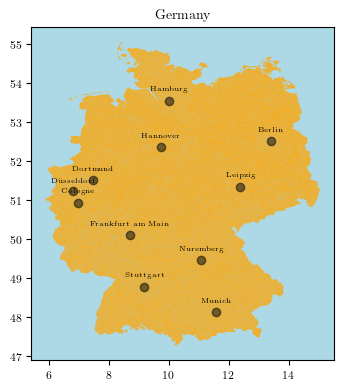

In [11]:
customizable_map_germany(zip_shapes, 'germany', True, path_plots, 'map_Germany.pdf', cm)

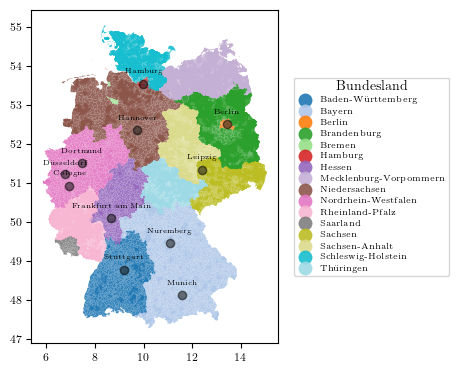

In [12]:
customizable_map_germany(germany, 'lander', True, path_plots, 'map_Lander.pdf', cm)

In [13]:
zip_inhabitants = pd.read_csv(path_data / 'plz_einwohner.csv', sep=',', dtype={'plz': str, 'einwohner': 'int'})
zip_inhabitants.head()

,plz,note,einwohner,qkm,lat,lon
0,01067,01067 Dresden,11957,6.866862,51.06019,13.71117
1,01069,01069 Dresden,25491,5.351816,51.03964,13.73030
2,01097,01097 Dresden,14821,3.297752,51.06945,13.73781
3,01099,01099 Dresden,28018,58.506789,51.09272,13.82842
4,01108,01108 Dresden,5876,16.447222,51.15180,13.79227


In [14]:
population = pd.merge(left=germany, right=zip_inhabitants, on='plz', how='left', suffixes=('_x', None)).rename(columns={'note_x':'note', 'qkm_x': 'qkm', 'einwohner_x': 'einwohner'})
population = population.loc[:,~population.columns.duplicated()].copy()
population.head()

,plz,note,qkm,einwohner,geometry,ags,ort,landkreis,bundesland,lat,lon
0,01067,01067 Dresden,6.866862,11957,"POLYGON ((13.68689 51.06395, 13.68734 51.06400...",14612000,Dresden,NaN,Sachsen,51.06019,13.71117
1,01069,01069 Dresden,5.351833,25491,"MULTIPOLYGON (((13.72009 51.04664, 13.72051 51...",14612000,Dresden,NaN,Sachsen,51.03964,13.73030
2,01097,01097 Dresden,3.297752,14821,"POLYGON ((13.72548 51.06860, 13.72629 51.06900...",14612000,Dresden,NaN,Sachsen,51.06945,13.73781
3,01099,01099 Dresden,58.506789,28018,"POLYGON ((13.74218 51.08979, 13.74231 51.08969...",14612000,Dresden,NaN,Sachsen,51.09272,13.82842
4,01108,01108 Dresden,16.447222,5876,"POLYGON ((13.76543 51.17491, 13.76567 51.17483...",14612000,Dresden,NaN,Sachsen,51.15180,13.79227


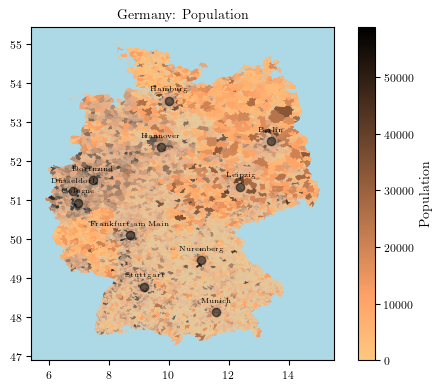

In [15]:
customizable_map_germany(population, 'population', True, path_plots, 'map_Germany_population.pdf', cm)

## Data - Heidelberg

In [16]:
def read_opendata_HD(path, file, sheet, cols, header):

    # Import Heidelberg open data (2021)
    # https://ww2.heidelberg.de/datenatlas/2021/
    
    # read in excel file
    read_in = pd.read_excel(path / file, \
                            sheet_name=sheet, \
                            usecols=cols, header=header)

    # Transpose
    HD = read_in.T

    # rename NaN in fulture header row
    HD.at[1,0]="Topic"
    HD.at[1,1]="Subtopic"
    HD.at[1,2]="Remove"
    HD.at[1,3]="Remove"
    HD.at[1,4]="Year"

    # Take first row as column name
    HD.columns = HD.iloc[0].tolist()
    # remove first row that was containing the column names 
    HD.drop(HD.index[0], inplace=True)

    # drop rows conataining diff or Heidelberg in the column 'year'
    HD = HD.loc[~HD.Year.isin(['diff', 'Heidelberg'])]
    # drop empty/unused columns
    HD.drop(columns=['Remove'], inplace=True)

    # Fill in NaNs
    HD['Topic']=HD.Topic.fillna(method='ffill')
    HD['Subtopic']=HD.Subtopic.fillna(method='ffill')

    #reset index
    HD.reset_index(drop=True, inplace=True)

    # convert relevant columns to categorical
    for col in ['Topic', 'Subtopic', 'Year']:
        HD[col] = HD[col].astype('category')

    return HD

In [17]:
HD = read_opendata_HD(path_data, 'Datenatlas_Open_Data_2021.xlsx', 'Stadtteile_Datenatlas', \
                 "B:AMJ", None)

In [18]:
print(HD.Subtopic.cat.categories.tolist())

['15- bis unter 45-Jährige Frauen', 'Anteil Deutsche', 'Anteil Einelternhaushalte', 'Anteil Einpersonenhaushalte', 'Anteil Einwohner 10 bis 17 Jahre', 'Anteil Einwohner 18 bis 29 Jahre', 'Anteil Einwohner 3 bis 5 Jahre', 'Anteil Einwohner 30 bis 44 Jahre', 'Anteil Einwohner 45 bis 64 Jahre', 'Anteil Einwohner 6 bis 9 Jahre', 'Anteil Einwohner 65 Jahre und älter', 'Anteil Einwohner 75 Jahre und älter', 'Anteil Einwohner unter 3 Jahre', 'Anteil Familien mit Kindern an allen Haushalten mit Kindern', 'Anteil Geschieden', 'Anteil Haushalte mit 1 Kind', 'Anteil Haushalte mit 2 Kindern', 'Anteil Haushalte mit 3 Kindern und mehr', 'Anteil Haushalte mit Kindern', 'Anteil Haushalte ohne Kinder', 'Anteil Ledig 18 Jahren und älter', 'Anteil Ledig unter 18 Jahren', 'Anteil Mehrpersonenhaushalte', 'Anteil Verheiratet', 'Anteil Verwitwet', 'Anteil bebauter Fläche', 'Anteil der 15- bis unter 45-Jährigen Frauen', 'Anteil der Zuzüge aus dem Stadtgebiet an allen Zuzügen', 'Anteil der männlichen Wohnbevöl

##### We such data at hands, we can do many things (e.g., correlations, time series, histograms, etc)
##### Here we will only plot one of the quantities for a given year 

In [19]:
def select_open_data_HD(df, column, year):

    sel=df.loc[(df.Subtopic.str.contains(column)) & (df.Year.isin([year]))].drop(columns=['Topic','Year']).set_index('Subtopic')
    sel2 = sel.T.reset_index(drop=False, names=['district'])
    sel2[column] = sel2[column].astype('float')
    return sel2

In [20]:
def get_geometry_HD(path, file):

    filename = path_data / file

    # read_in = gpd.read_file(filename, driver='LIBKML', 
                            
    read_in = gpd.read_file(filename, driver="LIBKML", allow_unsupported_drivers=True)
    #read_in.columns
    HD_geometry = read_in.loc[:,['Name','geometry']]

    return HD_geometry

geometry_HD = get_geometry_HD(path_data, 'admins_heidelberg.kml')

In [21]:
select_open_data_HD(HD, 'Anteil bebauter Fläche', 2015)

Subtopic,district,Anteil bebauter Fläche
0,Schlierbach,14.552035
1,Altstadt,10.537975
2,Bergheim,76.108910
3,Weststadt,86.934875
4,Südstadt,69.868552
5,Rohrbach,46.692107
6,Kirchheim,32.186143
7,Pfaffengrund,63.695739
8,Wieblingen,27.251228
9,Handschuhsheim,17.956845


In [22]:
def customizable_map_HD(big_df, column, year, geometry_file, path_data, path_plot, filename, cm):

    # use function to retrieve relevant data
    data_HD = select_open_data_HD(big_df, column, year)
    # use function to retrieve HD geometry
    geometry_HD = get_geometry_HD(path_data, 'admins_heidelberg.kml')

    #  merge the dfs 
    data = pd.merge(left=geometry_HD, right=data_HD, left_on='Name', right_on = 'district', \
                    how='left')
    
    # compute centroid
    '''
    - The area considered is very small (a city)
    - This is just to showcase some capabilities of geopandas 
    --> So we simply use the generic .centroid command 
    without extensive care of the projection chosen 
    '''
    data["centroid"] = data["geometry"].centroid
    
    # plot
    fig = plt.figure(figsize=(11*cm, 16*cm))
    ax = fig.add_subplot(111)
    
    title_plot = str(column) + ' in Heidelberg'
    
    data.plot(ax=ax, column=column, categorical=False, legend=True, 
              legend_kwds={"shrink":.5}, \
              cmap='copper_r', alpha=0.8,)

    ax.set(title=title_plot, xlabel = r'Longitude [deg]', ylabel = r'Latitude [deg]', 
           aspect=2.0, facecolor='white')
    
    cax = fig.get_axes()[1]
    cax.set_ylabel(column)

    # plot centroids
    ax.scatter(data.centroid.x, data.centroid.y, marker='o', s=3, c='red', alpha=0.5)
    # plot district name
    def annotate_df(row):  
        ax.annotate(row.Name, (row.centroid.x, row.centroid.y),
                    xytext=(row.centroid.x, row.centroid.y+0.004),
                    size=5,
                    ha='center',
                    color='navy')
    anno = data.apply(annotate_df, axis=1)

    file = path_plots / str(filename)
    fig.savefig(file, format='pdf')
 
    return data

/tmp/ipykernel_539375/582682174.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data["centroid"] = data["geometry"].centroid
/tmp/ipykernel_539375/582682174.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax.scatter(data.centroid.x, data.centroid.y, marker='o', s=3, c='red', alpha=0.5)


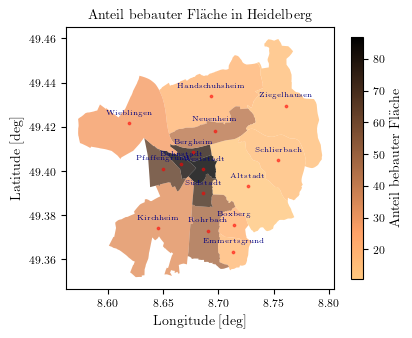

In [23]:
data = customizable_map_HD(HD, 'Anteil bebauter Fläche', 2015, 'admins_heidelberg.kml', \
                         path_data, path_plots, 'map_fraction_of_built-on_area_HD.pdf', cm)